In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mysql.connector
import ast
import sqlalchemy

In [2]:
   
def process_tweets(list_of_tweets):
    assert type(list_of_tweets) == str
    list_of_tweets = list_of_tweets.replace(", \"", ", \'")
    list_of_tweets = list_of_tweets.replace("\", ", "\', ")
    list_of_tweets = list_of_tweets.replace("[\"", "[\'")
    list_of_tweets = list_of_tweets.replace("\"]", "\']")
    #replace apostrophes in the form letter single quote letter
    all_letters = "abcdefghijklmnopqrstuvwxyz"
    for letter in all_letters:
        list_of_tweets = list_of_tweets.replace(f"\'{letter}", f"’{letter}")
        list_of_tweets = list_of_tweets.replace(f"{letter}\' ", f"{letter}’ ")
        list_of_tweets = list_of_tweets.replace(f"{letter}\'-", f"{letter}’-")
        list_of_tweets = list_of_tweets.replace(f"{letter}\'.", f"{letter}’.")
        list_of_tweets = list_of_tweets.replace(f"{letter}\'!", f"{letter}’!")
        list_of_tweets = list_of_tweets.replace(f"{letter}\'?", f"{letter}’?")

    tweets = ast.literal_eval(list_of_tweets.strip())
    try:
        assert(len(tweets) == 50)
    except:
        print("Assertion error: {}", tweets)
        print(len(tweets))
    return tweets

def read_generated_data():
    filename = "gpt_generation.txt"
    with open(filename, 'r') as f:
        data = f.readlines()
    #drop header
    data = data[1:]
    user_ids = [line.split(",")[0] for line in data]
    states = [line.split(",")[1] for line in data]
    index_tweet_start = [line.find("[") for line in data]
    tweets = [line[index_tweet_start[i]:] for i, line in enumerate(data)]
    tweets = [process_tweets(tweet) for tweet in tweets]
    data_df = pd.DataFrame({'user_id': user_ids, 'state': states, 'tweets': tweets})
    return data_df

gpt_data = read_generated_data()

In [3]:
def read_twitter_data(rand_seed):
    database = 'county_bias'
    cnx = mysql.connector.connect(user='shreyah', password='yQ~,K].U^MO1ybD]', host='localhost', database=database)
    cursor = cnx.cursor()
    query1 = "SELECT * FROM msgs_10pct_30_2012_en WHERE state = '{}' LIMIT 200000"
    query2 = "SELECT * FROM msgs_10pct_30_2013_en WHERE state = '{}' LIMIT 200000"

    state_codes = ['NY', 'MA', 'LA', 'MS']
    tweets_2012 = pd.DataFrame()
    for state in state_codes:
        query = query1.format(state)
        cursor.execute(query)
        temp = pd.DataFrame(cursor.fetchall(), columns=cursor.column_names)
        #decode from bytes to string
        temp["message"] = temp["message"].apply(lambda x: x.decode("utf-8"))
        temp = temp[temp['message'].str.split().str.len() > 5]
        #select exactly 50 tweets from each user, skip users with under 50 tweets
        user_ids = temp['user_id'].unique()
        np.random.seed(rand_seed)
        np.random.shuffle(user_ids)
        included_users = 0
        for user in user_ids:
            user_tweets = temp[temp['user_id'] == user]
            if(len(user_tweets) > 50):
                tweets_2012 = pd.concat([tweets_2012, user_tweets[:50]])
                included_users += 1
            if(included_users == 250):
                break
        print(state, len(tweets_2012))
            
    tweets_2013 = pd.DataFrame()
    for state in state_codes:
        query = query2.format(state)
        cursor.execute(query)
        temp = pd.DataFrame(cursor.fetchall(), columns=cursor.column_names)
        #decode from bytes to string
        temp["message"] = temp["message"].apply(lambda x: x.decode("utf-8"))
        temp = temp[temp['message'].str.split().str.len() > 5]
        #select exactly 50 tweets from each user, skip users with under 50 tweets
        user_ids = temp['user_id'].unique()
        np.random.seed(rand_seed)
        np.random.shuffle(user_ids)
        included_users = 0
        for user in user_ids:
            user_tweets = temp[temp['user_id'] == user]
            if len(user_tweets) > 50:
                tweets_2013 = pd.concat([tweets_2013, user_tweets[:50]])
                included_users += 1
            if(included_users == 250):
                break     
        print(state, len(tweets_2013))

    Tweets = pd.concat([tweets_2012, tweets_2013])
    print(len(Tweets))
    return Tweets

twitter_data = read_twitter_data(1)

NY 12500


In [ ]:
database='individualism_collectivism'
table = "purification_015"

cnx = mysql.connector.connect(user='shreyah', password='yQ~,K].U^MO1ybD]', host='localhost', database=database)
cursor = cnx.cursor()
query = "SELECT * FROM " + table
cursor.execute(query)
lexicon = pd.DataFrame(cursor.fetchall(), columns=cursor.column_names)
lexicon_indv = lexicon[lexicon["category"] == "INDIVIDUALIST"]
lexicon_coll = lexicon[lexicon["category"] == "COLLECTIVIST"]

def apply_lexicon(text, lexicon):
    score = 0
    for word in lexicon:
        # if(word == "world" or word == "diversity" or word == "creativity"): continue
        score += text.count(word)
    return score/len(text.split())    

In [ ]:
def get_scores(state_name, state_abbr, gpt_data, twitter_data):
    gpt_data_state = np.array((gpt_data[gpt_data["state"] == " {}".format(state_name)])["tweets"].tolist()).flatten()
    twitter_data_state = np.array((twitter_data[twitter_data["state"] == state_abbr])["message"].tolist()).flatten()

    gpt_data_text = " ".join(gpt_data_state)
    twitter_data_text = " ".join(twitter_data_state)

    indv_gpt = apply_lexicon(gpt_data_text, lexicon_indv["term"])
    coll_gpt = apply_lexicon(gpt_data_text, lexicon_coll["term"])
    indv_twitter = apply_lexicon(twitter_data_text, lexicon_indv["term"])
    coll_twitter = apply_lexicon(twitter_data_text, lexicon_coll["term"])
    return indv_gpt, coll_gpt, indv_twitter, coll_twitter


def get_differences(gpt_data, twitter_data):
    state_names = ["New York", "Massachusetts", "Louisiana", "Mississippi"]
    state_abbrs = ["NY", "MA", "LA", "MS"]
    results = []
    for i, state in enumerate(state_names):
        indv_gpt, coll_gpt, indv_twitter, coll_twitter = get_scores(state, state_abbrs[i], gpt_data, twitter_data)
        results.append([state, indv_gpt, coll_gpt, indv_twitter, coll_twitter])
        print(state, indv_gpt, coll_gpt, indv_twitter, coll_twitter)

    results_df = pd.DataFrame(results, columns=["state", "indv_gpt", "coll_gpt", "indv_twitter", "coll_twitter"])
    #normalize scores
    results_df["indv_gpt"] = results_df["indv_gpt"] / results_df["indv_gpt"].max()
    results_df["coll_gpt"] = results_df["coll_gpt"] / results_df["coll_gpt"].max()
    results_df["indv_twitter"] = results_df["indv_twitter"] / results_df["indv_twitter"].max()
    results_df["coll_twitter"] = results_df["coll_twitter"] / results_df["coll_twitter"].max()
    results_df["diff_gpt"] = results_df["indv_gpt"] - results_df["coll_gpt"]
    results_df["diff_twitter"] = results_df["indv_twitter"] - results_df["coll_twitter"]
    return results_df
                                                        

In [ ]:
VC_scores = [0.36666666666666653, 0.25, 0.6833333333333333, 0.55]
VC_scores = [0.5-x for x in VC_scores]
results_df = get_differences(gpt_data, twitter_data)
results_df["vc_score"] = VC_scores

New York 0.007543113285921652 0.001846408063028931 0.0019560386678555758 0.0034110370401822993
Massachusetts 0.006876625772945338 0.0037105876634773763 0.001993405755558983 0.0034047952321226427
Louisiana 0.005693145975752869 0.0018649960955052503 0.0014364055957365816 0.0032504996193376476
Mississippi 0.007653483544798135 0.0032706650423000353 0.0015707215194633512 0.003722870341711479


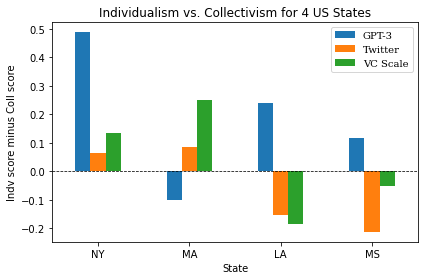

In [ ]:
#plot results in histogram
fig, ax = plt.subplots(figsize=(8,6))
#set font to serif
plt.rcParams['font.family'] = 'serif'
results_df.plot.bar(x='state', y=['diff_gpt', 'diff_twitter', 'vc_score'], ax=ax)
plt.ylabel("Indv score minus Coll score")
plt.title("Individualism vs. Collectivism for 4 US States")
plt.legend(["GPT-3", "Twitter", "VC Scale"])
#change xticks
plt.xticks(np.arange(4), ["NY","MA","LA","MS" ], rotation=0)
plt.xlabel("State")
plt.tight_layout()
#change font sizes
plt.rc('font', size=12)
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=10)
#horizontal line at 0
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.75)
plt.show()

